## <b>1. Key Points<b>

The VECM model is applied in the case time series are non-stationary but cointegrated (same Integration orders).

The Johansen test is used to test for cointegration in a set of non-stationary time series. It tests whether a linear combination of these series can be stationary, suggesting the existence of a long-term equilibrium relationship between them.

How the Johansen Test Guides the Decision
The Johansen test assesses the presence and number of cointegrating relationships among the variables by evaluating multiple lagged values simultaneously. Here’s how it works:

Null Hypothesis: For each test rank (r), the Johansen test’s null hypothesis is that there are r or fewer cointegrating relationships among the variables. For example, if you have three variables, the null hypotheses will be:

r = 0: No cointegrating relationship (variables are not cointegrated).
r = 1: One cointegrating relationship.
r = 2: Two cointegrating relationships.
Trace Statistic: For each rank r, the Johansen test calculates a trace statistic and compares it to critical values. If the trace statistic for a given rank exceeds the critical value, we reject the null hypothesis, implying at least r cointegrating relationships.

Choosing Cointegration Rank (r):

If r > 0, the test suggests that the variables are cointegrated, confirming the need for a VECM model to account for both long-term equilibrium and short-term fluctuations.
If r = 0 (no cointegration), the variables are not cointegrated, and a Vector Autoregressive (VAR) model without error correction is more appropriate.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.vector_ar.vecm import VECM
from statsmodels.tsa.api import VAR
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import jarque_bera
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')

In [4]:
us_unemp = pd.read_csv('US_UNEMPLOYMENT.csv')
us_unemp =  us_unemp.set_index('DATE')
us_unemp.columns =  ['UNEMP_RATE']
us_unemp.head(3)

,UNEMP_RATE
DATE,
1948-01-01,3.4
1948-02-01,3.8
1948-03-01,4.0


In [5]:
us_10y = pd.read_csv('US_10Y.csv')
us_10y =  us_10y.set_index('DATE')
us_10y.columns = ['10Y_RATE']
us_10y.head(3)

,10Y_RATE
DATE,
1982-01-01,7.623742
1982-02-01,7.656648
1982-03-01,7.128993


In [6]:
us_cpi = pd.read_csv('US_CPI.csv')
us_cpi = us_cpi.set_index('DATE')
us_cpi.columns = ['CPI']
us_cpi.head(3)

,CPI
DATE,
1968-01-01,3.651861
1968-02-01,3.673819
1968-03-01,4.142164


In [7]:
df_1 = (
    pd.concat([us_cpi, us_unemp, us_10y],
    axis = 1,
    join = 'inner') ).sort_index()

df_1.index = pd.to_datetime(df_1.index)

df_1.index = df_1.index.strftime('%Y-%m')

df_1.tail(3)

,CPI,UNEMP_RATE,10Y_RATE
DATE,,,
2024-07,4.164951,4.3,2.048396
2024-08,4.103706,4.2,1.664190
2024-09,4.010873,4.1,1.581581


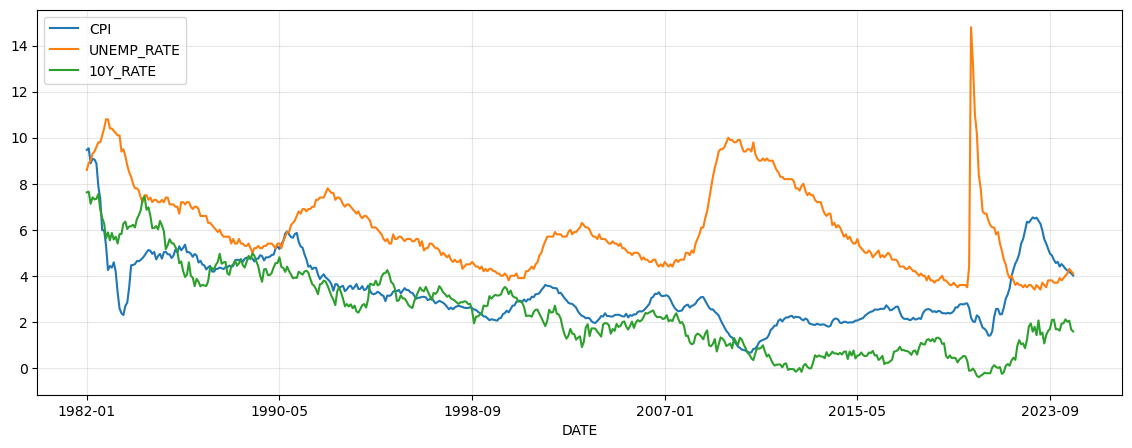

In [8]:
df_1.plot(figsize = (14,5))
plt.grid(True, alpha = 0.3);

In [9]:
# Run VECM on shorter time frame (20 years from 2000 - now)
df_2004 = df_1.loc['2004':]
df_2004.head(3)

,CPI,UNEMP_RATE,10Y_RATE
DATE,,,
2004-01,1.949813,5.7,1.701954
2004-02,2.037157,5.6,1.571581
2004-03,2.126567,5.8,1.470165


## <b>2. Pre-processing and set up the model<b>

1. `Stationary Check`: to ensure that the variables in the system are non-stationary and integrated of the same order.

2. Split the data set
3. 
2. `Johansen Test for Cointegration Rank`: This identifies the number of cointegrating relationships in the system, which is crucial for setting up the VECM. We select the cointegration rank by comparing the trace statistic to critical values.

3. `Optimal Lag Length Selection`: For VECM, we use the BIC criterion to determine the optimal lag length for the VAR part of the model, which is a good approach.

4. `Fitting the VECM Model`: The VECM class from statsmodels is used appropriately to fit the model.


5. `Post-Estimation Diagnostics`:\
5.1. Residual Diagnostics: The `Ljung-Box test` is used to check for autocorrelation in the residuals, and `ACF/PACF plots` provide a visual check. These are essential for ensuring the model’s adequacy and that residuals behave as expected.\
5.2. `Granger-causality` among pairs.

### 2.1. Stationary check

In [12]:
# CHECK STATIONARITY

def check_stationarity(data: pd.DataFrame) -> pd.DataFrame:
    def _run_tests(series):
        """Runs the ADF and KPSS tests on a single series."""
        result = {}
        series = series.dropna()  # Remove missing values
        
        # ADF test for stationarity (null hypothesis: series has a unit root, i.e., non-stationary)
        adf_test = adfuller(series)
        adf_pvalue = adf_test[1]
        result['ADF Test'] = "Stationary" if adf_pvalue < 0.05 else "Non-Stationary"

        # KPSS test for stationarity (null hypothesis: series is stationary)
        kpss_test = kpss(series, regression='ct')  # 'ct' for constant and trend
        kpss_pvalue = kpss_test[1]
        result['KPSS Test (Trend)'] = "Non-Stationary" if kpss_pvalue < 0.05 else "Stationary"
        
        # KPSS test for constant (non-zero mean)
        kpss_const_test = kpss(series, regression='c')  # 'c' for constant only
        kpss_const_pvalue = kpss_const_test[1]
        result['KPSS Test (Constant)'] = "Non-Stationary" if kpss_const_pvalue < 0.05 else "Stationary"

        return result

    # If the input is a pandas Series (single time series)
    if isinstance(data, pd.Series):
        data = data.to_frame()

    # Run the tests for each column in the DataFrame
    results = {}
    for column in data.columns:
        results[column] = _run_tests(data[column])

    # Convert the results dictionary into a DataFrame
    results_df = pd.DataFrame(results).T
    results_df.index.name = "Series"
    
    return results_df

In [13]:
check_stationarity(df_2004)

,ADF Test,KPSS Test (Trend),KPSS Test (Constant)
Series,,,
CPI,Non-Stationary,Non-Stationary,Non-Stationary
UNEMP_RATE,Non-Stationary,Non-Stationary,Non-Stationary
10Y_RATE,Non-Stationary,Non-Stationary,Non-Stationary


### 2.2. Check order of Integrations

In [15]:
def difference_until_pass_kpss(data: pd.DataFrame, max_diff=3, significance_level=0.05):
    """
    Perform differencing on the time series until it passes the KPSS test for stationarity
    or until the maximum number of differencing steps (max_diff) is reached.

    Parameters:
    - data: The original time series (pandas Series or DataFrame).
    - max_diff: The maximum number of differencing steps to apply.
    - significance_level: The significance level for the KPSS test (default is 0.05).

    Prints:
    - A message indicating whether the series became stationary or failed the KPSS test.
    """

    def kpss_test(ts):
        """Run KPSS test on the time series and return whether it passes the test (stationary)."""
        statistic, p_value, _, _ = kpss(ts, regression='c', nlags="auto")
        return p_value > significance_level  # If p-value is greater than significance level, the series is stationary

    def process_single_series(time_series, col_name):
        """Handle differencing for a single series."""
        d = 0  # Initialize differencing count
        diff_series = time_series.copy()

        # Loop to difference and test for stationarity using KPSS
        while d <= max_diff:
            if kpss_test(diff_series):
                print(f"'{col_name}' became stationary after {d} differencing(s).")
                return d  # Return the number of differencing steps taken to achieve stationarity
            else:
                d += 1
                if d <= max_diff:
                    diff_series = diff_series.diff().dropna()  # Apply differencing

        # If the loop ends without the series becoming stationary
        print(f"'{col_name}' failed the KPSS test after {max_diff} differencing(s).")
        return None  # Return None if the series does not become stationary

    # If the input is a pandas Series (single time series)
    if isinstance(data, pd.Series):
        process_single_series(data, data.name)

    # If the input is a pandas DataFrame (multiple time series)
    elif isinstance(data, pd.DataFrame):
        for column in data.columns:
            print(f"Processing '{column}':")
            process_single_series(data[column], column)
            print("\n" + "="*50 + "\n")  # Separator for readability between columns

    else:
        raise ValueError("Input must be a pandas Series or DataFrame.")

In [16]:
difference_until_pass_kpss(df_2004)

Processing 'CPI':
'CPI' became stationary after 1 differencing(s).


Processing 'UNEMP_RATE':
'UNEMP_RATE' became stationary after 1 differencing(s).


Processing '10Y_RATE':
'10Y_RATE' became stationary after 1 differencing(s).




### 2.3. Split data into Train and test

In [18]:
def split_data(df, Ntest):
    """
    Splits the DataFrame into training and test sets based on the specified number of test observations.
    
    Args:
        df (pd.DataFrame): The DataFrame to split.
        Ntest (int): Number of observations to include in the test set.
        
    Returns:
        train (pd.DataFrame): Training set (df excluding the last Ntest observations).
        test (pd.DataFrame): Test set (last Ntest observations of df).
    """
    if Ntest < 0 or Ntest > len(df):
        raise ValueError("Ntest must be between 0 and the length of the DataFrame")
    
    # Split data
    train = df.iloc[:-Ntest].copy()  # All rows except the last Ntest rows
    test = df.iloc[-Ntest:].copy()   # Last Ntest rows
    
    return train, test

In [19]:
len(df_2004)*0.25

62.25

In [20]:
train_1, test_1 = split_data(df_2004, 63)

In [21]:
cols_1 = df_2004.columns

In [22]:
df1_train = train_1[cols_1]

In [23]:
df1_test = test_1[cols_1]

### 2.4. Johansen Test to confirm VECM and choose Cointgeration ranks

In [25]:
def johansen_test(data, det_order=0, k_ar_diff=2):
    result = coint_johansen(data, det_order, k_ar_diff)
    trace_stat = result.lr1
    critical_values = result.cvt
    print("Trace Statistics:", trace_stat)
    print("Critical Values (95% level):", critical_values[:, 1])
    return trace_stat, critical_values

Choosing the det_order depends on the data characteristics:

If your data is believed to have no deterministic trend, set det_order=0.
For data with a non-zero mean but no trend, det_order=1 (intercept) is often used.
If you believe there’s a linear trend, you can try det_order=2 or 3.

The k_ar_diff parameter specifies the number of lagged difference terms to include in the test, essentially representing the number of lags for the VAR model used in the Johansen test.

A higher k_ar_diff value allows the model to account for more complex dynamics in the data, potentially capturing more intricate relationships.
Typical values range from 1 to 4, depending on the frequency of the data (e.g., monthly data might use a higher k_ar_diff).

From the `check_stationarity` we see that all the series have no trend, but non-zero mean. Hence, we can set `det_order = 1`.

In [27]:
trace_stat_1a, critical_values_1a = johansen_test(df1_train, det_order=2, k_ar_diff=2)

Trace Statistics: [42.5634463  15.42907218  4.96609376]
Critical Values (95% level): [nan nan nan]


In [28]:
trace_stat_1b, critical_values_1b = johansen_test(df1_train, det_order=1, k_ar_diff=2)

Trace Statistics: [39.73247684 10.74360448  1.26486361]
Critical Values (95% level): [35.0116 18.3985  3.8415]


In [29]:
trace_stat_1c, critical_values_1c = johansen_test(df1_train, det_order=1, k_ar_diff=3)

Trace Statistics: [40.49274955 13.02598785  1.74198126]
Critical Values (95% level): [35.0116 18.3985  3.8415]


In [30]:
trace_stat_1d, critical_values_1d = johansen_test(df1_train, det_order=0, k_ar_diff=3)

Trace Statistics: [26.2731859   4.62282971  1.42169689]
Critical Values (95% level): [29.7961 15.4943  3.8415]


<b> Intepret:<b>

1. First test:
* The critical values for this test are NaN, meaning this result cannot be interpreted fully without critical values.

2. Second test:
* The 1st trace statistic 39.73 is greater than the 1st critical value 35.0116, so we reject the null hypothesis of no cointegration (suggesting there is at least 1 cointegrating relationship).
* The 2nd trace statistic 10.74 is less than the 2nd critical value 18.3985, meaning we fail to reject the null hypothesis at this level, implying there is no evidence of more than one cointegrating relationship.
* Conclusion: There is likely 1 cointegrating relationship.

3. Third test:
* The 1st trace statistic 40.49 is greater than the 1st critical value 35.0116, so we reject the null hypothesis of no cointegration (suggesting at least 1 cointegrating relationship).
* The 2nd trace statistic 13.03 is less than the 2nd critical value 18.3985, so we fail to reject the null hypothesis of more than 1 cointegrating relationship.
* Conclusion: There is likely 1 cointegrating relationship.

4. Fourth test:
* The 1st trace statistic 26.27 is less than the 1st critical value 29.7961, meaning there is no evidence of cointegration in this test.
* Conclusion: No cointegrating relationship detected.

5. We conclude that there are <b>likely 1 cointegrating relationships and det_order = 1 is chosen for later test.<b>

### 2.5. Combine the Johansen test and running VAR to select the optimal parameters for VECM

* The Johansen test is used to choose the Cointegration rank.
* The lags for VECM models is used by running VAR and then select the one with the lowest BIC.

In [33]:
# Function to run the Johansen test and select the optimal lag length using AIC/BIC
def vecm_find_parameter(data, maxlags=10, ic='bic', det_order=0):
    """
    Combines the Johansen test and lag length selection (VAR) for VECM.
    
    Args:
        data (pd.DataFrame): Time series data (each column is a series).
        maxlags (int): Maximum number of lags to test for VAR model.
        ic (str): Information criterion to select lags ('aic' or 'bic').
        det_order (int): Deterministic order for Johansen test (default=0: constant term).
        
    Returns:
        coint_rank (int): The cointegration rank (number of cointegrating relationships).
        optimal_lag_length (int): The optimal lag length based on AIC/BIC for VAR model.
    """
    
    # Step 1: Johansen test to find the cointegration rank
    johansen_result = coint_johansen(data, det_order=det_order, k_ar_diff=maxlags)
    trace_stat = johansen_result.lr1  # Trace statistics
    critical_values = johansen_result.cvt[:, 1]  # Critical values at 95% level
    
    # Determine cointegration rank (where trace_stat > critical_value)
    coint_rank = np.where(trace_stat > critical_values)[0].max() + 1
    print(f"Selected Cointegration Rank: {coint_rank}")
    
    # Step 2: Select optimal lag length using BIC with a VAR model
    var_model = VAR(data)
    lag_orders = var_model.select_order(maxlags=maxlags)
    optimal_lag_length = lag_orders.selected_orders[ic]
    
    print(f"Optimal Lag Length ({ic.upper()}): {optimal_lag_length}")
    
    return coint_rank, optimal_lag_length

In [34]:
coint_rank, optimal_lag_length = vecm_find_parameter(df1_train, maxlags=10, det_order = 1) # use det_order chosen above

Selected Cointegration Rank: 1
Optimal Lag Length (BIC): 2


* These should be the intial inputs for our model. We can later try to adjust to see if we can improve it.

## <b>3. Define VECM model and run<b>

In [37]:
def vecm_run(train_data, test_data, maxlags, coint_rank, plot=False, diagnostics=False, summary=False):
    """
    Fits a VECM model on train_data, forecasts on test_data, calculates AIC and BIC, 
    and optionally plots parameters, diagnostics, and model summary.
    
    Args:
        train_data (pd.DataFrame): Training data for fitting the model.
        test_data (pd.DataFrame): Test data for evaluating the forecast.
        maxlags (int): Optimal number of lags to use in the model.
        coint_rank (int): Cointegration rank (number of cointegrating relationships).
        plot (str/bool): Plotting options - False (no plot), 'separate' (separate plots), 'all' (one plot for all series).
        diagnostics (bool): If True, displays residual diagnostics (residuals, ACF, PACF, Ljung-Box, and Jarque-Bera tests).
        summary (bool): If True, prints the summary of the VECM model.
    
    Returns:
        train_actual (pd.DataFrame): Actual values of the training set.
        train_fitted (pd.DataFrame): Fitted (in-sample predicted) values for the training set.
        test_actual (pd.DataFrame): Actual values of the test set.
        test_forecast (pd.DataFrame): Forecasted values for the test set.
    """
    
    # Fit VECM model on training data
    vecm = VECM(train_data, k_ar_diff=maxlags, coint_rank=coint_rank)
    vecm_fit = vecm.fit()
    
    # Calculate AIC and BIC
    def calculate_num_params(vecm_fit):
        neqs = vecm_fit.neqs  # Number of equations (number of variables)
        k_ar_diff = vecm_fit.k_ar  # Number of lags
        coint_rank = vecm_fit.coint_rank  # Cointegration rank
        num_params = neqs**2 * k_ar_diff + coint_rank * neqs
        return num_params

    num_params = calculate_num_params(vecm_fit)
    log_likelihood = vecm_fit.llf  # Log-likelihood of the model
    n_obs = vecm_fit.nobs
    
    aic = -2 * log_likelihood + 2 * num_params
    bic = -2 * log_likelihood + num_params * np.log(n_obs)
    print(f"AIC: {aic}, BIC: {bic}")
    
    # Obtain in-sample fitted values for the training data
    train_fitted = pd.DataFrame(vecm_fit.fittedvalues, index=train_data.index[-len(vecm_fit.fittedvalues):], columns=train_data.columns)
    train_actual = train_data.iloc[-len(train_fitted):]  # Aligning index to match fitted values
    
    # Forecasting future values on the test data period
    test_forecast = vecm_fit.predict(steps=len(test_data))
    test_forecast = pd.DataFrame(test_forecast, index=test_data.index, columns=train_data.columns)
    test_actual = test_data  # To keep structure consistent for future evaluations

    # Plot the parameters if requested
    if plot:
        fig, ax = None, None
        if plot == 'all':
            fig, ax = plt.subplots(figsize=(14, 6))
            for column in train_data.columns:
                ax.plot(train_data.index, train_data[column], alpha = 0.5)
                ax.plot(train_fitted.index, train_fitted[column], linestyle='--', label=f'Fitted values {column}')
                ax.plot(test_data.index, test_data[column], label=f'Actual values {column}', alpha = 0.5)
                ax.plot(test_forecast.index, test_forecast[column], linestyle='--', label=f'Forecast values {column}')
            ax.legend(loc = 'best')
            ax.set_title(f"VECM - All Series (Cointegration: {coint_rank}, Lags = {maxlags})", color =  'darkred')
            ax.set_xlabel("Time")
            ax.set_ylabel("Value")
            plt.grid(True, alpha=0.3)
            plt.show()

        elif plot == 'separate':
            for column in train_data.columns:
                fig, ax = plt.subplots(figsize=(14, 5))
                ax.plot(train_data.index, train_data[column], color='orange', alpha = 0.5)
                ax.plot(train_fitted.index, train_fitted[column], linestyle='--', label=f'Fitted values {column}', color='green')
                ax.plot(test_data.index, test_data[column], label=f'Actual values {column}', color='orange', alpha = 0.5)
                ax.plot(test_forecast.index, test_forecast[column], linestyle='--', label=f'Forecast values {column}', color='blue')
                ax.legend(loc = 'best')
                ax.set_title(f"VECM - {column} (Cointegration: {coint_rank}, Lags = {maxlags})", color =  'darkred')
                ax.set_xlabel("Time")
                ax.set_ylabel("Value")
                plt.grid(True, alpha=0.3)
                plt.show()

    # Print model summary if requested
    if summary:
        print(vecm_fit.summary())
    
    # Post model diagnostics if requested
    if diagnostics:
        residuals = pd.DataFrame(vecm_fit.resid, columns=train_data.columns, index=train_data.index[-len(vecm_fit.resid):])

        # Resdiual plots
        fig, axs = plt.subplots(nrows=len(train_data.columns), ncols=3, figsize=(15, 4 * len(train_data.columns)))
        for i, col in enumerate(train_data.columns):
            axs[i, 0].plot(residuals.index, residuals[col])
            axs[i, 0].set_title(f'Residuals for {col}')
            plot_acf(residuals[col], ax=axs[i, 1], lags=20)
            axs[i, 1].set_title(f'ACF of Residuals for {col}')
            plot_pacf(residuals[col], ax=axs[i, 2], lags=20)
            axs[i, 2].set_title(f'PACF of Residuals for {col}')
        plt.tight_layout()
        plt.show()

        # Ljung-Box test
        print("Ljung-Box Test Results:")
        for col in train_data.columns:
            lb_test = acorr_ljungbox(residuals[col], lags=[10], return_df=True)
            print(f"{col}:\n{lb_test}\n")

        # JB test
        print("Jarque-Bera Test Results:")
        for col in train_data.columns:
            jb_stat, jb_pvalue = jarque_bera(residuals[col])
            print(f"{col}: JB Stat = {jb_stat:.4f}, p-value = {jb_pvalue:.4f}")
    
    return train_actual, train_fitted, test_actual, test_forecast

AIC: -645.4163368350701, BIC: -549.1317522498274


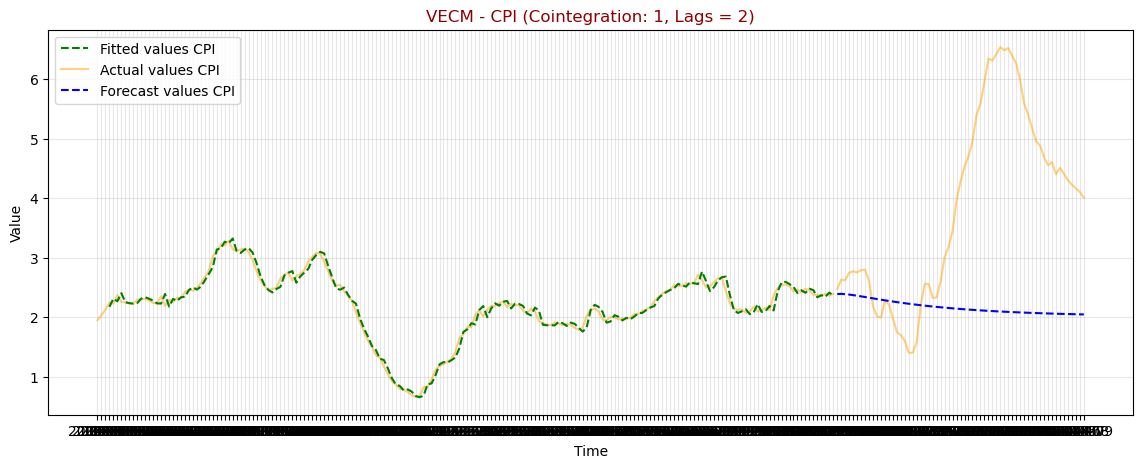

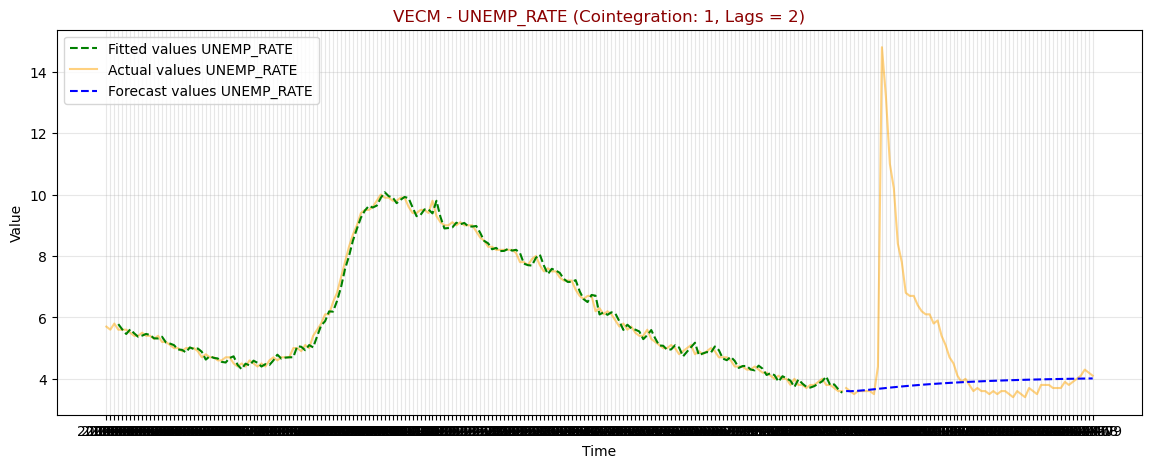

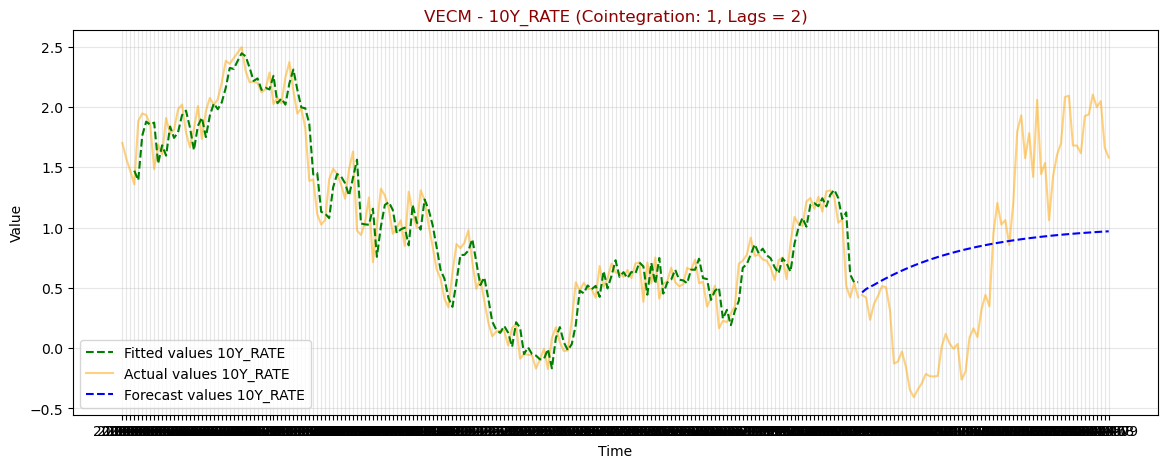

Det. terms outside the coint. relation & lagged endog. parameters for equation CPI
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
L1.CPI            0.3266      0.073      4.495      0.000       0.184       0.469
L1.UNEMP_RATE    -0.0413      0.036     -1.140      0.254      -0.112       0.030
L1.10Y_RATE       0.0148      0.033      0.453      0.650      -0.049       0.079
L2.CPI            0.1989      0.073      2.739      0.006       0.057       0.341
L2.UNEMP_RATE    -0.0310      0.036     -0.864      0.388      -0.101       0.039
L2.10Y_RATE      -0.0286      0.033     -0.868      0.385      -0.093       0.036
Det. terms outside the coint. relation & lagged endog. parameters for equation UNEMP_RATE
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
L1.CPI 

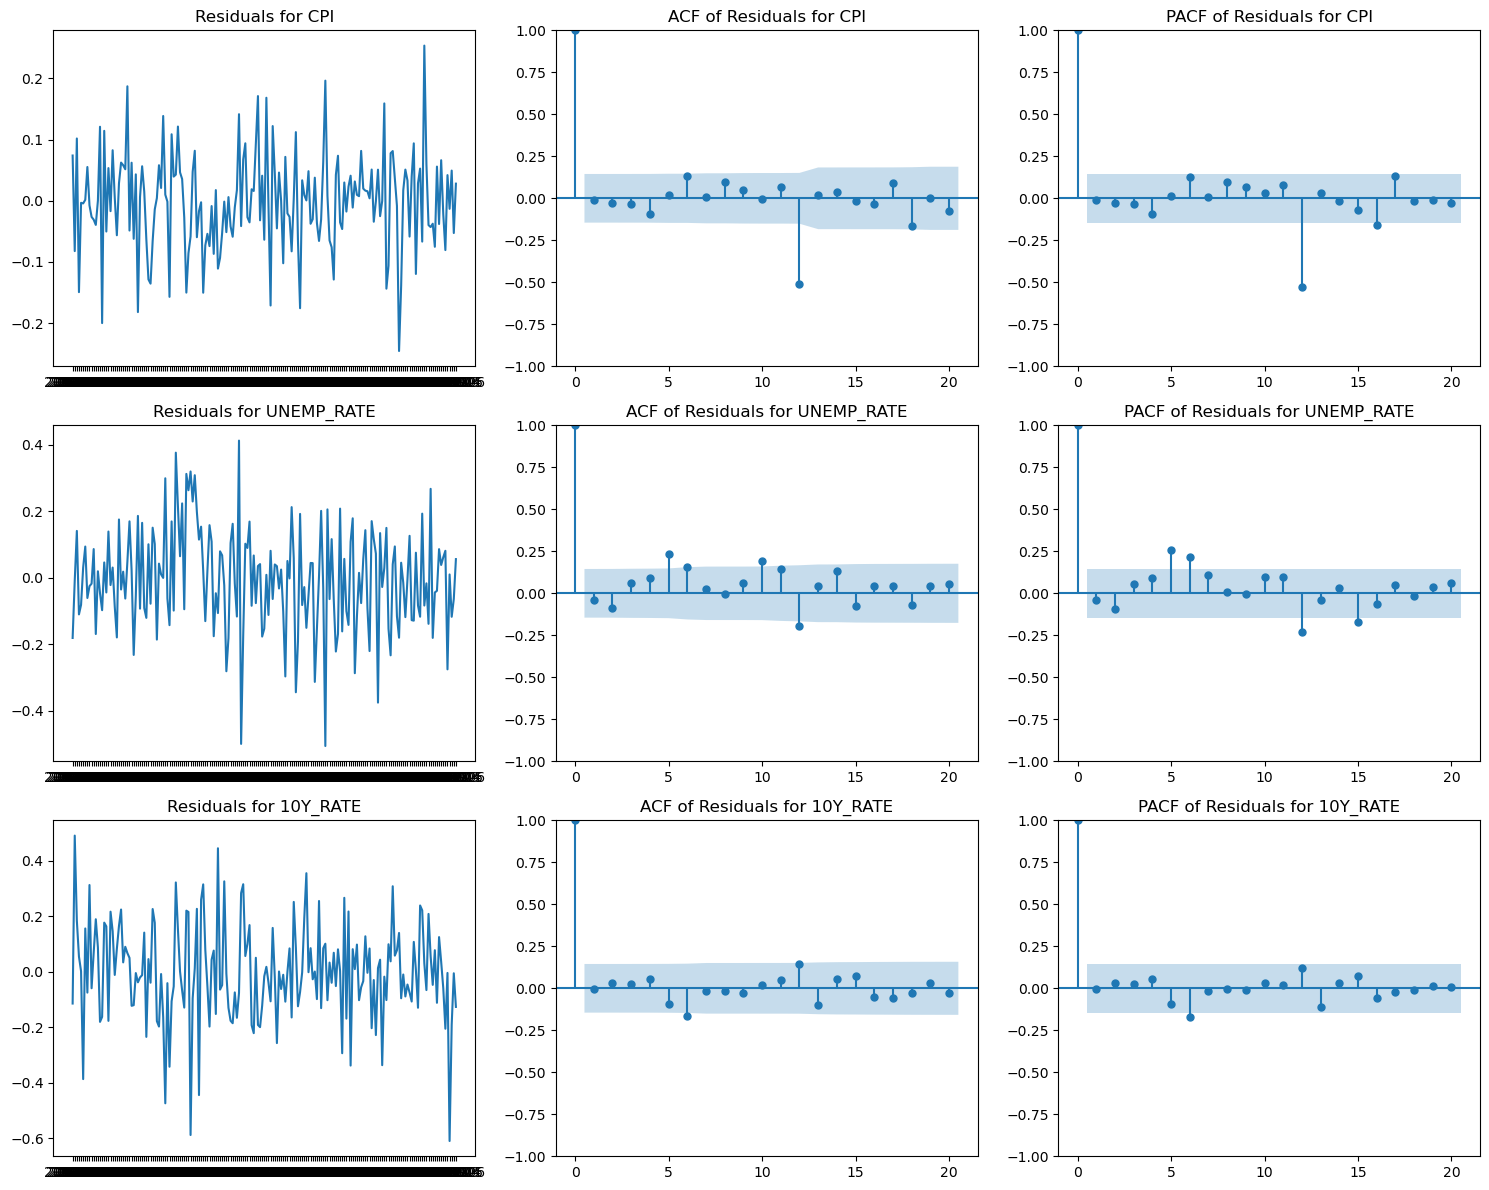

Ljung-Box Test Results:
CPI:
     lb_stat  lb_pvalue
10  7.686386    0.65944

UNEMP_RATE:
     lb_stat  lb_pvalue
10  27.50314   0.002167

10Y_RATE:
     lb_stat  lb_pvalue
10  8.153116   0.613884

Jarque-Bera Test Results:
CPI: JB Stat = 3.8797, p-value = 0.1437
UNEMP_RATE: JB Stat = 3.2676, p-value = 0.1952
10Y_RATE: JB Stat = 11.2978, p-value = 0.0035


In [38]:
train_actual, train_fitted, test_actual, test_forecast = (
    vecm_run(df1_train, df1_test, 
             maxlags=2, coint_rank=1, 
             plot = 'separate', diagnostics = True, summary = True) )

<b>Interpretation of Ljung-Box and Jarque-Bera test tesults:<b>

1. <b>Ljung-Box test results:<b>
* The Ljung-Box test checks for autocorrelation in time series data up to a specified lag (lag 10 in this case). The null hypothesis is that there is no autocorrelation.
* CPI: The p-value is well above the common significance level of 0.05. Therefore, we fail to reject the null hypothesis, suggesting that there is no significant autocorrelation in the CPI data up to the 10th lag.
* UNEMP_RATE: The p-value is much lower than 0.05, meaning we reject the null hypothesis of no autocorrelation. This indicates that there is significant autocorrelation in the Unemployment Rate series up to the 10th lag.
* 10Y_RATE: The p-value is quite high (greater than 0.05), so we fail to reject the null hypothesis, indicating no significant autocorrelation in the 10-Year Treasury Rate data up to the 10th lag.

2. <b>Jarque-Bera test results:<b>
* The Jarque-Bera (JB) test checks whether a series is normally distributed. The null hypothesis is that the data follows a normal distribution.
* CPI: The p-value is above 0.05, meaning we fail to reject the null hypothesis, suggesting that the CPI data follows a normal distribution.
* UNEMP_RATE: The p-value is also above 0.05, so we fail to reject the null hypothesis. This suggests that the Unemployment Rate data follows a normal distribution.
* 10Y_RATE: The p-value is below 0.05, so we reject the null hypothesis of normality. This suggests that the 10-Year Treasury Rate data does not follow a normal distribution.

3. <b>Overall summary:<b>
* Autocorrelation:\
a. Unemployment Rate shows significant autocorrelation, suggesting its values are influenced by past values.\
b. CPI and 10-Year Treasury Rate show no significant autocorrelation.
* Normality:\
a. Both CPI and Unemployment Rate appear to follow a normal distribution.\
b. 10-Year Treasury Rate does not follow a normal distribution and may need transformation or a more complex model to account for this non-normality.

## <b>4. Evaluate models<b>

In [41]:
def evaluate_varma(y_true, y_pred, logged_cols=None):
    """
    Calculate common evaluation metrics for both univariate and multivariate models, 
    handling cases where some series are log-transformed and others are not, and return a DataFrame.
    
    Args:
        y_true: A pandas DataFrame or a 1D/2D array of actual values.
        y_pred: A pandas DataFrame or a 1D/2D array of predicted values.
        logged_cols: List of column names (for DataFrame) or indices (for arrays) that are log-transformed.
                     If evaluating a single series, pass a boolean indicating if the series is logged.
    
    Returns:
        A pandas DataFrame with evaluation metrics (MAE, MSE, RMSE, MAPE, R²) as columns.
        For multivariate models, the index will be the variable names.
    """
    metrics = {}
    
    # Check if it's a univariate case (1D array or a pandas Series)
    if isinstance(y_true, (pd.Series, np.ndarray)) and y_true.ndim == 1:
        # If logged_cols is a boolean and True, apply exp transformation
        if isinstance(logged_cols, bool) and logged_cols:
            y_true = np.exp(y_true)
            y_pred = np.exp(y_pred)
        
        # Calculate metrics for the single series
        mae = mean_absolute_error(y_true, y_pred)
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100 if np.all(y_true != 0) else np.inf
        r2 = r2_score(y_true, y_pred)
        
        metrics = {
            'MAE': round(mae, 6),
            'MSE': round(mse, 6),
            'RMSE': round(rmse, 6),
            'MAPE': round(mape, 6) if not np.isinf(mape) else np.nan,
            'R²': round(r2, 6)
        }
        
        # Convert the result to a DataFrame with a single row
        return pd.DataFrame([metrics], index=['Univariate'])

    else:
        # If logged_cols is None, assume no logging; otherwise, handle list of log-transformed columns
        logged_cols = logged_cols if logged_cols is not None else []
        
        # Convert to DataFrame if numpy array is provided
        if isinstance(y_true, np.ndarray):
            y_true = pd.DataFrame(y_true)
        if isinstance(y_pred, np.ndarray):
            y_pred = pd.DataFrame(y_pred)
        
        # Loop through each variable (column) and calculate metrics individually
        for col in y_true.columns:
            actual = y_true[col]
            predicted = y_pred[col]
            
            # If the column is logged, revert it back to the original scale
            if col in logged_cols:
                actual = np.exp(actual)
                predicted = np.exp(predicted)
            
            # Calculate evaluation metrics
            mae = mean_absolute_error(actual, predicted)
            mse = mean_squared_error(actual, predicted)
            rmse = np.sqrt(mse)
            mape = np.mean(np.abs((actual - predicted) / actual)) * 100 if np.all(actual != 0) else np.inf
            r2 = r2_score(actual, predicted)
            
            # Store metrics for the current variable
            metrics[col] = {
                'MAE': round(mae, 6),
                'MSE': round(mse, 6),
                'RMSE': round(rmse, 6),
                'MAPE': round(mape, 6) if not np.isinf(mape) else np.nan,  # Handle division by zero in MAPE
                'R²': round(r2, 6)
            }
    
        # Convert the dictionary to a DataFrame
        metrics_df = pd.DataFrame(metrics).T  # Transpose to have variables as rows
        return metrics_df

In [42]:
evaluate_varma(train_actual, train_fitted)

,MAE,MSE,RMSE,MAPE,R²
CPI,0.059707,0.006092,0.078053,2.927505,0.979984
UNEMP_RATE,0.120903,0.023379,0.152903,2.085847,0.993649
10Y_RATE,0.131522,0.030309,0.174094,36.245366,0.935653


In [43]:
evaluate_varma(test_actual, test_forecast)

,MAE,MSE,RMSE,MAPE,R²
CPI,1.815924,5.499703,2.345144,39.780836,-1.200137
UNEMP_RATE,1.278027,6.557866,2.560833,17.697272,-0.235209
10Y_RATE,0.662540,0.554590,0.744708,585.516629,0.213054


<b>Overview of the result:<b>

## <b>5. Granger causality among pairs<b>

In [46]:
from statsmodels.tsa.stattools import grangercausalitytests

def generalized_granger_causality_matrix(data: pd.DataFrame, max_lag: int, significance_level: float = 0.05, verbose: bool = False):
    """
    Perform Granger Causality tests between all pairs of time series in the input data
    and return a matrix of p-values. Print a summary of significant Granger-causal relationships.
    
    Parameters:
    -----------
    data : pd.DataFrame
        A dataframe where each column represents a time series.
    max_lag : int
        The maximum number of lags to consider for the Granger causality tests.
    significance_level : float, default 0.05
        The p-value threshold to determine significance of Granger causality.
    verbose : bool, default False
        If True, prints detailed test results for each pair of series.
    
    Returns:
    --------
    p_value_matrix : pd.DataFrame
        A matrix (DataFrame) of p-values where entry (i, j) is the p-value of testing
        if series i Granger-causes series j.
    """
    n_series = data.shape[1]
    columns = data.columns
    p_value_matrix = pd.DataFrame(np.nan, index=columns, columns=columns)

    print("\nGranger Causality Results:")
    print(f"{'Cause':<15} {'Effect':<15} {'P-Value':<10} {'Significant'}")
    print("-" * 50)

    for i in range(n_series):
        for j in range(n_series):
            if i != j:
                # Extract the two series we want to test
                cause_series = data.iloc[:, i]
                effect_series = data.iloc[:, j]
                
                # Create a DataFrame with both cause and effect series
                pair_data = pd.DataFrame({columns[i]: cause_series, columns[j]: effect_series})

                # Run Granger causality test
                try:
                    test_result = grangercausalitytests(pair_data, max_lag, verbose=verbose)
                    
                    # Extract the p-value for each lag
                    p_values = [test_result[lag][0]['ssr_ftest'][1] for lag in range(1, max_lag + 1)]
                    
                    # Store the minimum p-value in the matrix
                    min_p_value = min(p_values)
                    p_value_matrix.iloc[i, j] = min_p_value

                    # Check if the p-value is significant
                    is_significant = "Yes" if min_p_value < significance_level else "No"

                    # Print the result for this pair
                    print(f"{columns[i]:<15} {columns[j]:<15} {min_p_value:<10.4f} {is_significant}")
                
                except Exception as e:
                    print(f"Error testing causality between {columns[i]} and {columns[j]}: {e}")
                    p_value_matrix.iloc[i, j] = np.nan

    # Return the full p-value matrix as DataFrame
    return p_value_matrix

In [47]:
generalized_granger_causality_matrix(df_2004, max_lag = 1, verbose = False)


Granger Causality Results:
Cause           Effect          P-Value    Significant
--------------------------------------------------
CPI             UNEMP_RATE      0.0090     Yes
CPI             10Y_RATE        0.0487     Yes
UNEMP_RATE      CPI             0.2792     No
UNEMP_RATE      10Y_RATE        0.5562     No
10Y_RATE        CPI             0.0374     Yes
10Y_RATE        UNEMP_RATE      0.0877     No


,CPI,UNEMP_RATE,10Y_RATE
CPI,NaN,0.009000,0.048726
UNEMP_RATE,0.279154,NaN,0.556244
10Y_RATE,0.037443,0.087687,NaN


* The Granger causality test helps determine if one time series can forecast another.

1. <b>CPI and UNEMP_RATE:<b>
* CPI → UNEMP_RATE: The p-value is 0.0090, indicating strong statistical significance. This suggests that changes in CPI can help predict changes in the Unemployment Rate.
* UNEMP_RATE → CPI: The p-value is 0.2792, which is not statistically significant. This implies that the Unemployment Rate does not Granger-cause CPI.
* Interpretation: There is a one-way causality where CPI can forecast Unemployment rate, but not the other way around.

2. <b>CPI and 10Y_RATE:<b>
* CPI → 10Y_RATE: The p-value is 0.0487, which is statistically significant. This indicates that CPI helps forecast the 10-Year Treasury Rate.
* 10Y_RATE → CPI: The p-value is 0.0374, meaning it is statistically significant. This suggests that changes in the 10-Year Treasury Rate help predict changes in CPI.
* Interpretation: CPI Granger-causes 10-Year Treasury Rate, and vice versa.

3. <b>UNEMP_RATE and 10Y_RATE:<b>
* UNEMP_RATE → 10Y_RATE: The p-value is 0.5562, indicating not statistically significance. This suggests that the Unemployment Rate does not help forecast the 10-Year Treasury Rate.
* 10Y_RATE → UNEMP_RATE: The p-value is 0.0877, which is not statistically significant. This indicates that the 10-Year Treasury Rate does not help predict the Unemployment Rate.
* Interpretation: There is no predictive power by using Unemployment Rate and 10-Year Treasury Rate to predict each other.

4. <b>Summary of Causal Relationships:<b>
* There is bidirectional Granger causality between CPI and both Unemployment Rate and 10-Year Treasury Rate. CPI helps predict both Unemployment Rate and 10-Year Treasury Rate, and the 10-Year Treasury Rate can also predict CPI.
* The Unemployment Rate does not significantly predict either CPI or the 10-Year Treasury Rate.

<b> What are the insights for VECM? How can we utilize the best of this model? <b>